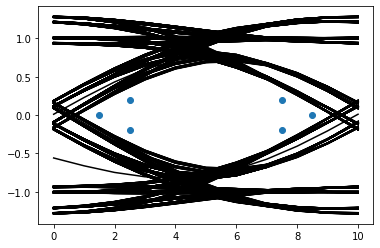

In [3]:
#Importing the data from TMDS_DATA_GEN script.
%run TMDS_DATA_GEN.py #with the changes this should already output the 3 components mentioned (yGre, yRed, yBlu)

In [6]:
#amount of bits for two lines in a frame:
num_bits = 720*2*10*10 #144,000
len(yRed)/num_bits #max number of repetitions possible to obtain average

240.0

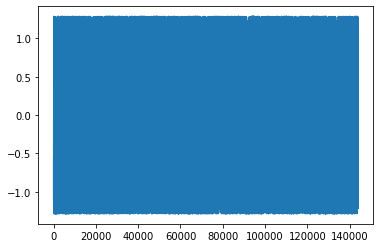

In [6]:
plt.plot(yRed[10:num_bits+10])

# Continous Wavelet Transform

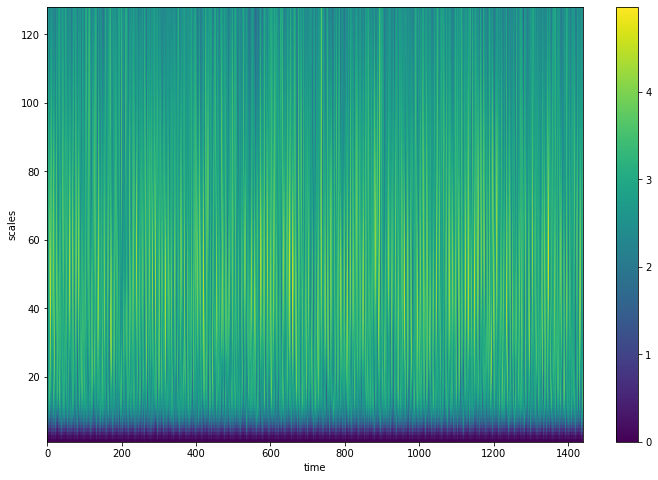

In [14]:
#Implemented using PYWT library for continous wavelet transform analysis.

import numpy as np
import matplotlib.pyplot as plt
import pywt

def cwt(name,wavelet,num_bits,data,scales,dt=1,reps=1,image='yes'):
    """    
    
    Computes Continous Wavelet Transform (CWT) coefficients of the input data using different wavelets and plots the
    value of the CWT coefficients as a function of time and scales. If reps>1 it computes the coefficients over #reps 
    non-overlapping windows of data from the original signal and averages result.
    
    For a list of all available continous wavelets use: pywt.wavelist(kind='continuous')
    
    scales can be changed based on the input signal. Recommended range: (1,2**n + 1) for n in integers.
    
    input: (str: name of the channel of data, str: name of wavelet to use for CWT, int: number of bits to 'cut of' 
    from the total data to use in the analysis, np.array: array containing the signal, float: time step between two consecutive time
    domain samples, default is 1 second, int: , str: 'yes'to save the image as jpg and 'no' to not save it, default is yes.
    )
    
    output: produces 2D color map where the x-axis corresponds to time and y-axis corresponds to scales and the color
    represents the magnitude. Data is scaled to the range [0,abs(wavelet_coefficients)] before mapping to colors.
    
    Note: to map from scales to frequencies one can use pywt.scale2frequency(wavelet, scales)/dt or freqs/dt
    
    Documentation: https://pywavelets.readthedocs.io/en/latest/ref/cwt.html
    
    """
    
    data = data[10:]
    coef = np.zeros((len(scales),num_bits))
    #print(coef)
    #print('-----------------------')
    for i in range(reps):
        
        coef_i, freqs = pywt.cwt(data[(i*num_bits):((i+1)*num_bits)],scales,wavelet) #computes the coefficients and corresponding frequencies of wavelet transform
        #print(coef_i)
        #print('------------------1-------------------')
        
        coef += np.abs(coef_i)
        #print(coef)
        #print('-------------------')
        
    coef = coef/reps
    #print(coef)
    
    plt.figure(figsize = (12,8))
    c = plt.imshow(coef, origin='lower',aspect='auto', interpolation='none', vmin=0, vmax=coef.max(),extent=(0,num_bits*dt,scales[0],scales[-1]))  # doctest: +SKIP
    plt.colorbar(c)
    plt.ylabel('scales')
    plt.xlabel('time')
    if image=='yes':
        plt.savefig(wavelet+'_'+name+'.png') #saving as png since pdf does not compile properly
    plt.show()
    
    return 

#Sample scales and time step for one channel of an HDMI signal. Uses mexican hat wavelet.
scales = np.arange(1,129,1)
dt = 0.01
cwt('Red','mexh',num_bits,yRed,scales,dt,50,'no')

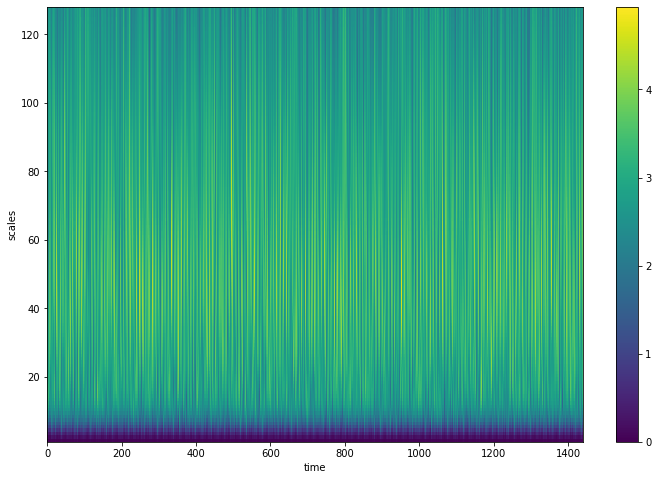

In [9]:
cwt('Blue_avg','mexh',num_bits,yBlu,scales,dt,50,'yes')

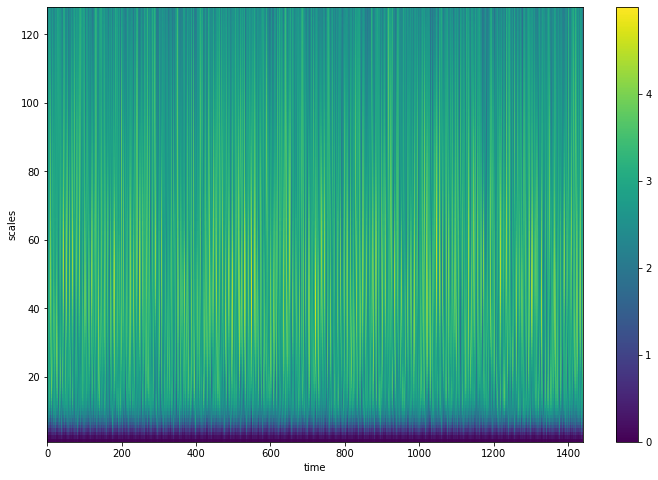

In [10]:
cwt('Green_avg','mexh',num_bits,yGre,scales,dt,50,'yes')

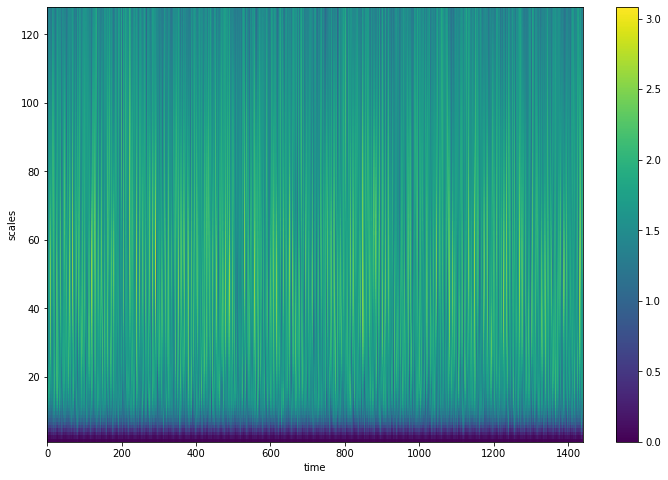

In [12]:
cwt('Mixed','mexh',num_bits,yTot,scales,dt,50,'no')

# Wigner-Ville Distribution

In [10]:
#defining the function that will yield the spectogram and wigner ville distribution

import tftb
import scipy.signal as sig


def spectro_WVD(data,num_bits=0,dt=1):
    
    """
    
    Computes the Short Time Fourier Transform (STFT) with its times and frequencies for plotting + times, frequencies 
    and coefficients of wigner-ville distribution (WVD).
    
    input: (int: number of bits to 'cut of' from the total data to use in the analysis, np.array: array containing the signal, float: 
    time step between two consecutive time domain samples,
    
    output: 
    
    f_stft = frequencies of the short fourier transform corresponding to y-axis in spectogram
    t_tsft = times of the short fourier transform corresponding to x-axis in spectogram
    Zxx = coefficients in short fourier transform
    
    tfr_wvd = coefficients of WVD
    ts = time stamps correspondent to x-axis in WVD plot
    f_wvd = frequencies correspondent to y-axis in WVD plot. 
    
    Note: Here Zxx, f_stft need to be shifted as in 'plotting_WVD()' for better representation.
    Default is to have first half with positive frequencies and second half with negative frequencies
    
    documentation:  
    
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
    https://tftb.readthedocs.io/en/latest/introduction.html https://pypi.org/project/tftb/
    
    """

    #if num_bits != 0:
    #    signal = data[10:num_bits+10]
    #if num_bits == 0:
    #    signal = data
    
    signal = data[10:num_bits+10]
    #ignores 10 bits as these are not real signal data. Unlike other methods we do not average so we only need num_bits points
 
    
    freq_s = 1/dt  # sampling frequency
    ts = np.arange(num_bits) * dt  #timestamps
    
    # Calculating Power of the short time fourier transform (SFTF):
    nperseg = 2**6  # window size of the STFT
    f_stft, t_stft, Zxx = sig.stft(signal, freq_s, nperseg=nperseg, 
                               noverlap=nperseg-1, return_onesided=False)
   
        
    
    # Calculating Wigner-Ville Distribution
    #wvd = tftb.processing.WignerVilleDistribution(signal[:len(signal)//2], timestamps=ts[10:(num_bits+10)//2])
    wvd = tftb.processing.WignerVilleDistribution(signal, timestamps=ts)
    tfr_wvd, t_wvd, f_wvd = wvd.run()
    
    return f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd


def plotting_WVD(f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd, name):    
    
    """
    
    Function to use together with spectro_WVD(). 
    
    Input: come from the output of spectro_WVD(), for explanation on input see the corresponding
    comments of the latter function.
    
    output: 
    1st plot: spectogram with y-axis shifted to show the zero frequency in the middle. x-axis corresponds to time domain
    with the magnitude squared of the Zxx coefficients mapped to colors.

    2nd plot: Wigner-Ville distribution plot with y an x axis as for the 1st plot. Coefficients of WVD mapped to colors.

    
    
    """
    
    # shifting the frequency axis for better representation
    Zxx = np.fft.fftshift(Zxx, axes=0)
    f_stft = np.fft.fftshift(f_stft)
    
    dt = ts[1] - ts[0] #recalculating time step
    
    f, axx = plt.subplots(2, 1,figsize=(10,10))
    
    df1 = f_stft[1] - f_stft[0]  # frequency step
    im = axx[0].imshow(np.real(Zxx * np.conj(Zxx)), aspect='auto', #here Zxx*np.conj(Zxx) = |Zxx|^2 for spectogram
              interpolation=None, origin='lower',
              extent=(ts[0] - dt/2, ts[-1] + dt/2,
    
                      f_stft[0] - df1/2, f_stft[-1] + df1/2))
    axx[0].set_ylabel('frequency [Hz]')
    plt.colorbar(im, ax=axx[0])
    axx[0].set_title('spectrogram')

    # Due to implementation of WT, the maximum frequency is half of
    # the sampling Nyquist frequency, e.g. 125 Hz instead of 250 Hz, and the sampling # is 2 * dt instead of dt
    
    f_wvd = np.fft.fftshift(np.fft.fftfreq(tfr_wvd.shape[0], d= 2* dt))
    df_wvd = f_wvd[1]-f_wvd[0]  # the frequency step in the WVT
    im = axx[1].imshow(np.fft.fftshift(tfr_wvd, axes=0),aspect='auto', origin='lower',
           extent=(ts[0] - dt/2, ts[-1] + dt/2,
                   f_wvd[0]-df_wvd/2, f_wvd[-1]+df_wvd/2),vmin=0) 
    #here we have set the vmin = 0 to see the figures better but in reality the WVD has negative components since data is real
    #vmin=0,vmax=abs(tfr_wvd).max()
    
    axx[1].set_xlabel('time [s]')
    axx[1].set_ylabel('frequency [Hz]')
    plt.colorbar(im, ax=axx[1])
    axx[1].set_title('Wigner-Ville Transform-'+name)
    plt.show()
    
    return

In [12]:
testing = tftb.processing.WignerVilleDistribution(yRed[:10], timestamps=np.arange(10)) #testing the type of output obtained from WVD method
tfr_wvd, t_wvd, f_wvd = testing.run() #step necessary to obtain the frequencies, times and coefficients

tfr_wvd.dtype #verifying that is not complex

dtype('float64')

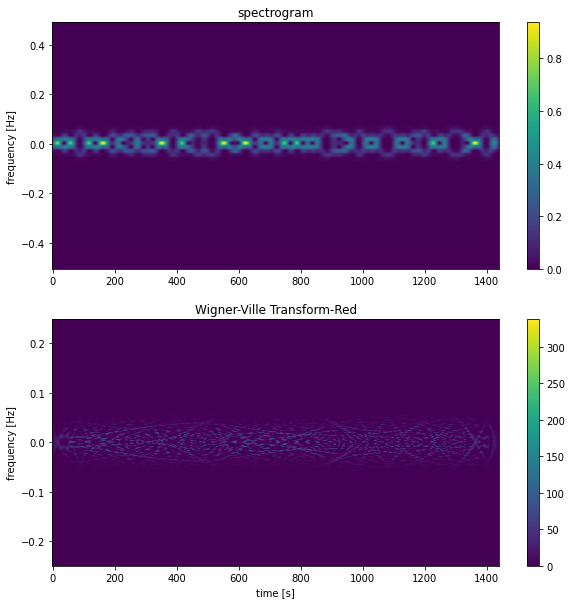

"\nf_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd = spectro_WVD(yBlu,num_bits)\nplotting_WVD(f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd,'Blue')\n\nf_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd = spectro_WVD(yGre,num_bits)\nplotting_WVD(f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd,'Grey')\n\nf_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd = spectro_WVD(yTot,num_bits)\nplotting_WVD(f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd,'Mixed')\n"

In [51]:
#calling the function spectro_WVD(). Using num_bits would produce an exception since we would run out of memory
#then only 1/100 is used to carry out the analysis.
f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd = spectro_WVD(yRed,num_bits//100,0.1) 
plotting_WVD(f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd,'Red')


#the following lines were commented out as they contain the same anlaysis but for different channels. Similar results were achieved
"""
f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd = spectro_WVD(yBlu,num_bits)
plotting_WVD(f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd,'Blue')

f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd = spectro_WVD(yGre,num_bits)
plotting_WVD(f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd,'Grey')

f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd = spectro_WVD(yTot,num_bits)
plotting_WVD(f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd,'Mixed')
"""
"""

# Periodogram 


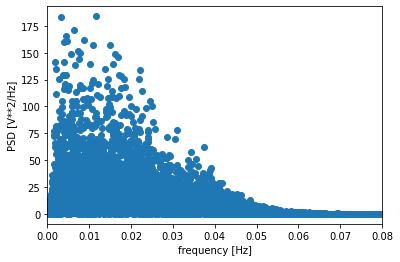

In [7]:
from scipy import signal

x = yRed[10:num_bits+10]
dt = 1
fs = 1/dt
f, Pxx_den = signal.periodogram(x, fs)
plt.plot(f,Pxx_den,'o')

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim(0,0.08)
plt.show()

In [11]:
def period(num_bits,data,dt,reps):
    
    """
    
    input: (int: number of bits to 'cut of' from the total data, np.array: array containing the signal, float: 
    time step between two consecutive time domain samples, int:number of repetitions over which average will be computed)
    
    output: 
    f: frequencies associated to time domain signal
    Pxx: Power Spectral Density corresponding to the frequencies from 'f'.
    
    """
    data = data[10:] #10 first bits ignored as these are not real signal data.
    fs = 1/dt #sampling frequency
    f, Pxx_den = sig.periodogram(data[:num_bits], fs) #used to obtain the length of Pxx_den
    Pxx_tot = np.zeros(len(Pxx_den)) #array with equal shape as Pxx_den.
    
    for i in range(reps):
        Pxx_tot += sig.periodogram(data[(i*num_bits):((i+1)*num_bits)],fs)[1] #adding up all the realizations of Pxx_den
        
    Pxx = Pxx_tot/reps #averages over all realizations
    
    return f, Pxx

def plot_period(f,Pxx_den,lim):
    plt.plot(f,Pxx_den)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.xlim(-0.001,lim)
    plt.show()
    

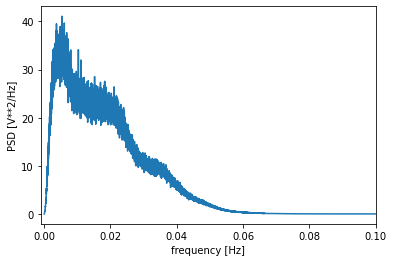

In [12]:
f, Pxx_den = period(num_bits,yRed,1,200) 
plot_period(f,Pxx_den,0.1)

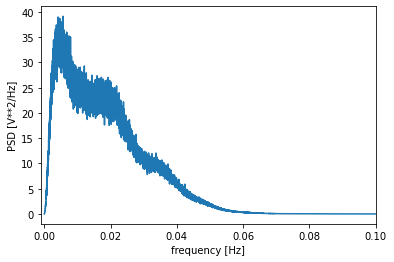

In [13]:
f, Pxx_den = period(num_bits,yBlu,1,200)
plot_period(f,Pxx_den,0.1)

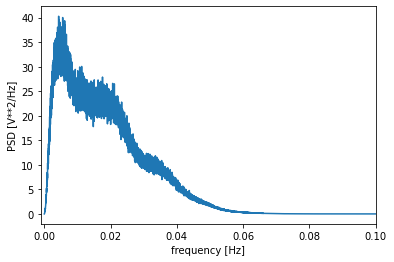

In [14]:
f, Pxx_den = period(num_bits,yGre,1,200)
plot_period(f,Pxx_den,0.1)

In [15]:
#Calculating the periodogram for the 3 different channels

f, Pxx_denR = period(num_bits,yRed,1,230)
f, Pxx_denB = period(num_bits,yBlu,1,230)
f, Pxx_denG = period(num_bits,yGre,1,230)

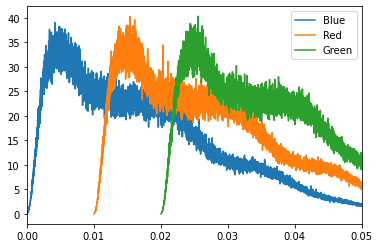

In [16]:
plt.plot(f,Pxx_denB,label='Blue')
plt.plot(f+0.01,Pxx_denR,label='Red')
plt.plot(f+0.02,Pxx_denG,label='Green')
plt.xlim(0,0.05)
plt.legend()
plt.show()

# ------------------------ USB ---------------------------------- (should be re run after I updated the previous functions)

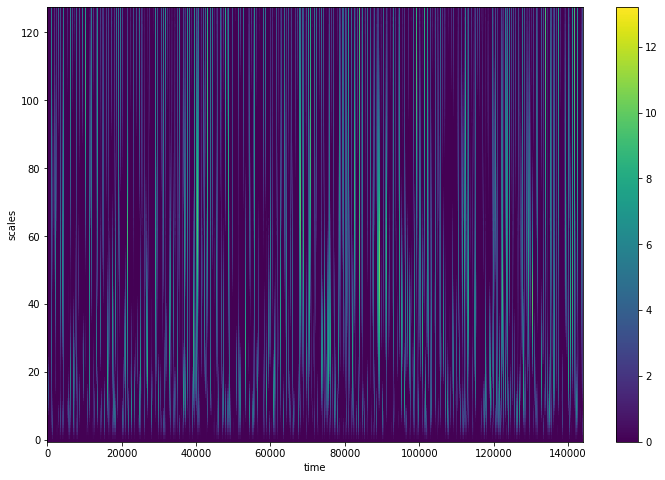

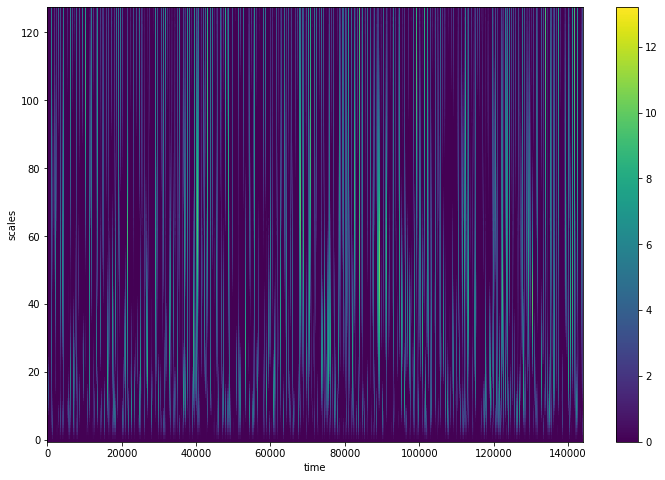

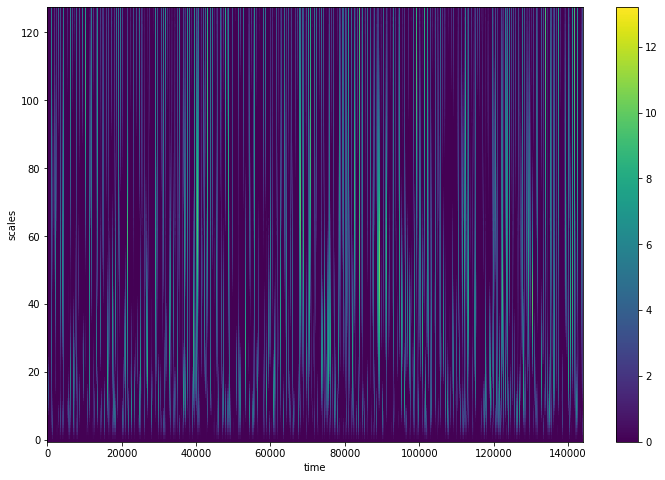

In [48]:
cwt('RedO','mexh',num_bits,yRedO,scales)
cwt('BlueO','mexh',num_bits,yBluO,scales)
cwt('GreyO','mexh',num_bits,yGreO,scales)

In [26]:
#loading the data generated by Shorouk on npy format
D_m = np.load("D_m.npy")
D_p = np.load("D_p.npy")

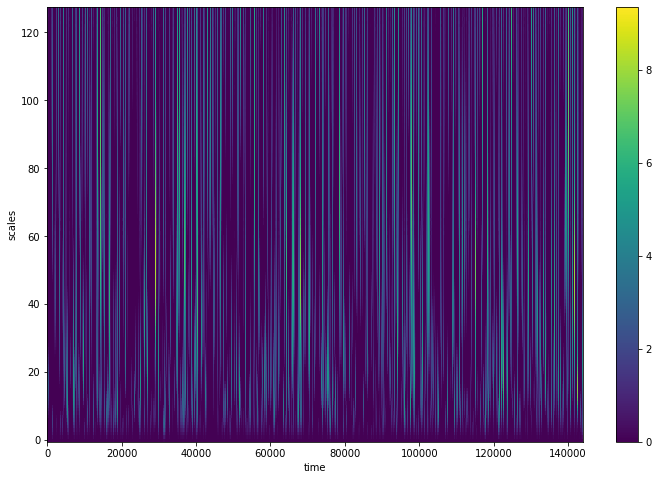

In [24]:
yTotO = np.add(0.4 * yRedO, 0.3 * yGreO)
yTotO = np.add(yTot, 0.3 * yBluO)

cwt('MixO','mexh',num_bits,yTotO,scales)

Text(0.5, 0, 'time')

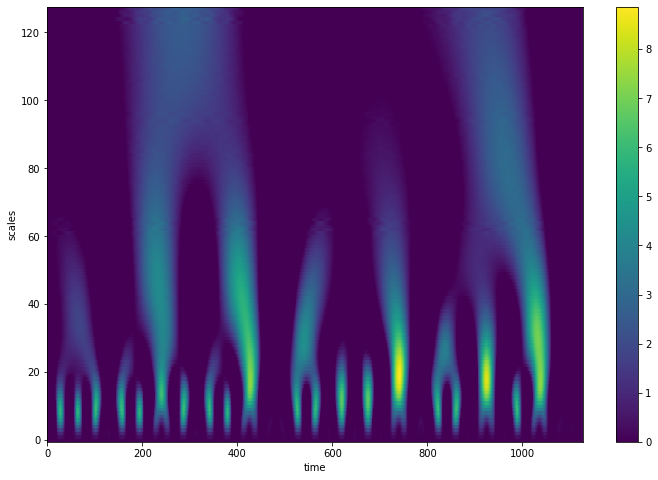

In [31]:
coef, freqs = pywt.cwt(D_m,scales,'mexh') #note: freqs and pywt.scale2frequency produce the same as long as we provide the correct time step 
plt.figure(figsize = (12,8))
c = plt.imshow(coef, origin='lower',aspect='auto', interpolation='none', vmin=0, vmax=abs(coef).max())  # doctest: +SKIP
plt.colorbar(c)
plt.ylabel('scales')
plt.xlabel('time')

Text(0.5, 0, 'time')

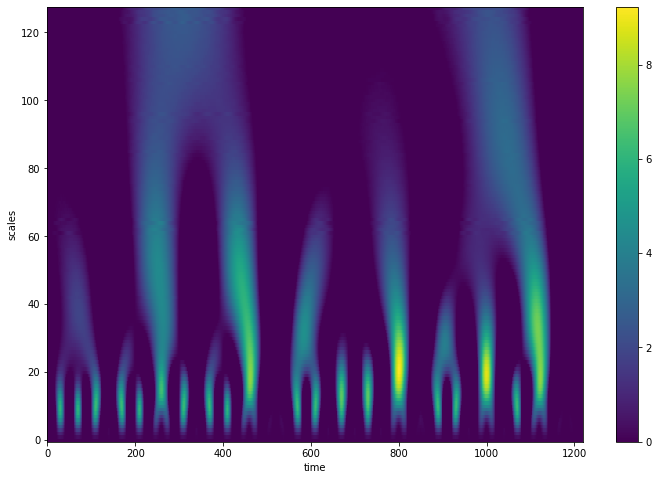

In [29]:
coef, freqs = pywt.cwt(D_p,scales,'mexh') #note: freqs and pywt.scale2frequency produce the same as long as we provide the correct time step 
plt.figure(figsize = (12,8))
c = plt.imshow(coef, origin='lower',aspect='auto', interpolation='none', vmin=0, vmax=abs(coef).max())  # doctest: +SKIP
plt.colorbar(c)
plt.ylabel('scales')
plt.xlabel('time')

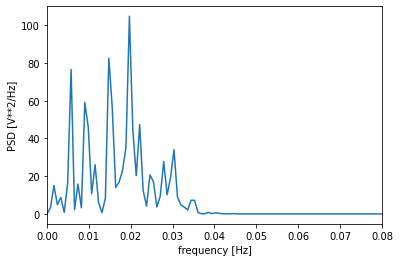

In [34]:
x = D_p
dt = 1
fs = 1/dt
f, Pxx_den = signal.periodogram(x, fs)
plt.plot(f,Pxx_den)

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim(0,0.08)
plt.show()

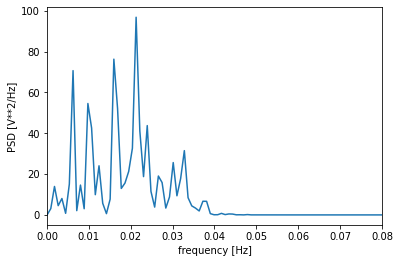

In [35]:
x = D_m
dt = 1
fs = 1/dt
f, Pxx_den = signal.periodogram(x, fs)
plt.plot(f,Pxx_den)

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim(0,0.08)
plt.show()

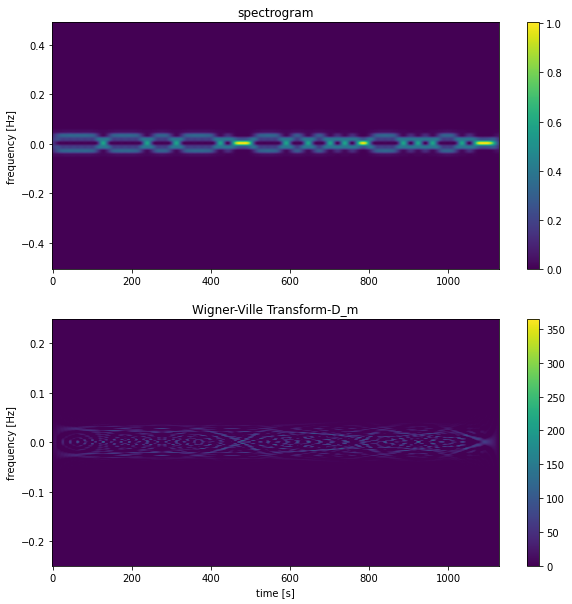

In [40]:
f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd = spectro_WVD(D_m)
plotting_WVD(f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd,'D_m')

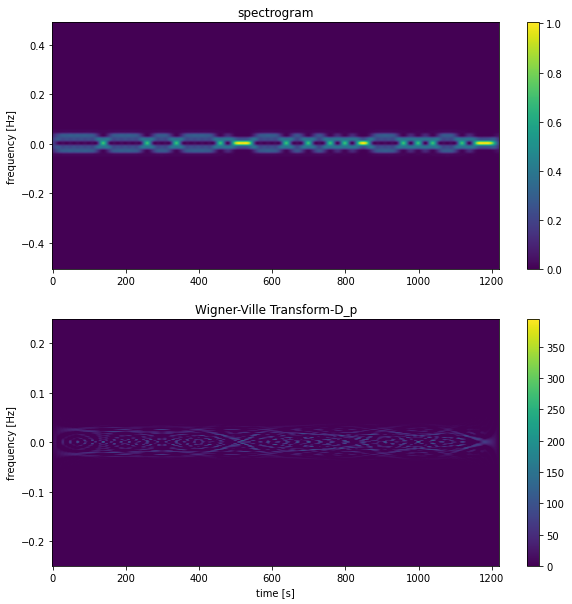

In [41]:
f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd = spectro_WVD(D_p)
plotting_WVD(f_stft, t_stft, Zxx, tfr_wvd, ts, f_wvd,'D_p')